## Analysis of contribution scores
Visualize what motifs the model looks for using DeepExplain

In [1]:
# Must restart the kernel for this
from deepexplain.tensorflow import DeepExplain

from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle
from decimal import Decimal

import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib_config
import seaborn as sns

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import utils_data
import model

Using TensorFlow backend.


In [2]:
reload(matplotlib_config)
matplotlib_config.paper_config()

In [3]:
from bpnet.cli.contrib import ContribFile
from bpnet.plot.tracks import plot_tracks, to_neg
from concise.utils.plot import seqlogo

Instructions for updating:
Colocations handled automatically by placer.


2019-09-26 11:07:03,477 [WARNING] From /data/ouga04b/ag_gagneur/home/karollus/.conda/envs/karollus-env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [4]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)

In [5]:
# Function to create an in-silico SNP array
nuc_dict = {'a':[1.0,0.0,0.0,0.0],'c':[0.0,1.0,0.0,0.0],'g':[0.0,0.0,1.0,0.0], 'u':[0.0,0.0,0.0,1.0], 
            't':[0.0,0.0,0.0,1.0], 'n':[0.0,0.0,0.0,0.0], 'x':[1/4,1/4,1/4,1/4]}
permutation_array = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,0.0,0.0,1.0]])

def create_permutations(seq, min_len=None):
    n = len(seq) * 4
    seq = seq.lower()
    one_hot = np.array([nuc_dict[x] for x in seq])
    one_hot_permuted = np.repeat(one_hot[np.newaxis,:,:], n, axis=0)
    for i in range(len(seq)):
        one_hot_permuted[i*4:(i*4)+4,i] = permutation_array
    if min_len is not None:
        diff = min_len - len(seq)
        if diff > 0:
            padding = np.zeros((n+1,diff, 4))
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
            one_hot_permuted = np.concatenate([padding, one_hot_permuted], axis=1)
        if diff < 0:
            one_hot_permuted = one_hot_permuted[np.abs(diff)*4:,np.abs(diff):,:]
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,np.abs(diff):,:], one_hot_permuted], axis=0)
        if diff == 0:
            one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    else:
        one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    return one_hot_permuted

def create_snv_array(seq, model, min_len=None,
                     postproc_mean=5.58621521, postproc_sd=1.34657403,
                    add_frame=False, add_library=False, suppress_postproc=False):
    if add_frame:
        frame = utils.build_frame(len(seq), (len(seq)*4) + 1)
        predictions = model.predict([create_permutations(seq, min_len=min_len), frame])
    elif add_library:
        indicator = np.zeros(((len(seq)*4) + 1,2))
        indicator[:,1] = 1
        predictions = model.predict([create_permutations(seq, min_len=min_len), indicator])
    else:
        predictions = model.predict(create_permutations(seq, min_len=min_len))
    if min_len is not None and not suppress_postproc:
        predictions =  predictions * postproc_sd + postproc_mean
    delta = np.log2(predictions[1:]/predictions[0])
    if min_len is not None and len(seq) > min_len:
        delta = delta.reshape((min_len, 4))
        diff = len(seq) - min_len
        padding = np.zeros((diff, 4))
        delta = np.concatenate([padding, delta], axis=0)
    else:
        delta = delta.reshape((len(seq), 4))
    return delta

def encode_df(df, one_hot_col="utr", add_library=True):
    one_hot_fn = utils_data.OneHotEncoder(one_hot_col)
    encoded_df =  one_hot_fn(df)
    if add_library:
        max_len = df[one_hot_col].str.len().max()
        indicator = np.zeros((max_len,2))
        indicator[:,1] = 1
        return [encoded_df, indicator]
    else: return encoded_df

def explain_deeply(encoded_df, batchsize=64):
    K.clear_session()
    sess = K.get_session()
    with DeepExplain(session=sess) as de:
        utr_model = load_model("utr_model_100_residual.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
        input_tensor = utr_model.layers[0].input
        target_tensor = utr_model(input_tensor)
        return de.explain('grad*input', target_tensor, input_tensor, encoded_df, batch_size=batchsize)

### In silico mutagenesis

In [ ]:
# get input sequences
df_disease = pd.read_csv("../Data/Calvo/Calvo_disease.tsv", sep="\t")
encoded_df_wt = encode_df(df_disease.iloc[0:1])
encoded_df_snv = encode_df(df_disease.iloc[0:1], one_hot_col="snv")
hbb = df_disease["utr"].iloc[0]
hbb_snv = df_disease["snv"].iloc[0]
encoded_df_hbb = np.concatenate([encoded_df_wt, encoded_df_snv], axis = 0)

utr_model = load_model("utr_model_combined_residual.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
arr = create_snv_array(hbb, utr_model, add_library=True)
arr_snv = create_snv_array(hbb_snv, utr_model, add_library=True)

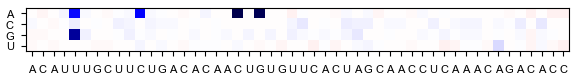

In [7]:
fig_dims = (7.0, 5.0)
font_size=8

fig, ax = plt.subplots()
ax.imshow(np.transpose(arr), vmin=-0.85, vmax=0.85, cmap="seismic")
ax.set_xticks(np.arange(0,50))
ax.set_xticklabels(list(hbb.replace("T","U")), fontsize=font_size)
ax.set_yticks(np.arange(0,4))
ax.set_yticklabels(["A","C","G","U"], fontsize=font_size)
fig.set_size_inches(fig_dims)

fig.savefig("../Graphics/motifs/hbb_bar.svg")

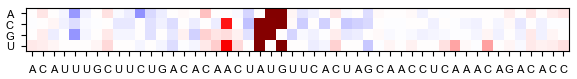

In [8]:
fig_dims = (7.0, 5.0)
font_size=8

fig, ax = plt.subplots()
im = ax.imshow(np.transpose(arr_snv), vmin=-0.85, vmax=0.85, cmap="seismic")
ax.set_xticks(np.arange(0,50))
ax.set_xticklabels(list(hbb_snv.replace("T","U")), fontsize=font_size)
ax.set_yticks(np.arange(0,4))
ax.set_yticklabels(["A","C","G","U"], fontsize=font_size)
fig.set_size_inches(fig_dims)

fig.savefig("../Graphics/motifs/hbbsnv_bar.svg")

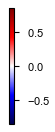

In [19]:
fig = plt.figure(figsize=(1.0,1.5))
plt.gca().set_visible(False)
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=8)
fig.savefig("../Graphics/motifs/colormap_bar.svg")

### Grad x input for HBB

In [9]:
# get input sequences
df_disease = pd.read_csv("../Data/Calvo/Calvo_disease.tsv", sep="\t")
encoded_df_wt = encode_df(df_disease.iloc[0:1], add_library=False)
encoded_df_snv = encode_df(df_disease.iloc[0:1], one_hot_col="snv", add_library=False)
hbb = df_disease["utr"].iloc[0]
hbb_snv = df_disease["snv"].iloc[0]
encoded_df_hbb = np.concatenate([encoded_df_wt, encoded_df_snv], axis = 0)

In [10]:
hbb_attrib = explain_deeply(encoded_df_hbb)

2019-09-26 11:08:20,653 [INFO] DeepExplain: running "grad*input" explanation method (2)
2019-09-26 11:08:20,665 [INFO] Model with multiple inputs: False


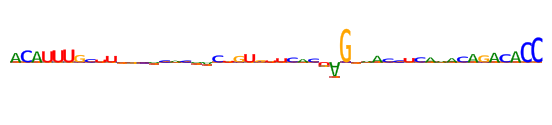

In [11]:
fig_dims = (7.0, 1.5)

fig,ax = plt.subplots()
seqlogo(hbb_attrib[0], vocab="RNA", ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(-1.75, 1.75)
#ax.set_ylabel("")
#ax.tick_params(axis='both', which='major', labelsize=10)

sns.despine(fig, bottom=True, left=True)
fig.set_size_inches(fig_dims)
fig.savefig("../Graphics/motifs/contrib_hbb.svg")

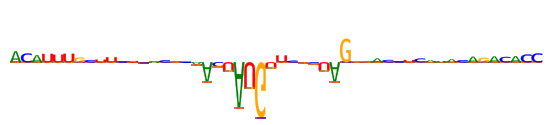

In [12]:
fig_dims = (7.0, 1.5)

fig,ax = plt.subplots()
seqlogo(hbb_attrib[1], vocab="RNA", ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_ylim(-1.75, 1.75)
#ax.set_ylabel("")
#ax.tick_params(axis='both', which='major', labelsize=10)

sns.despine(fig, bottom=True, left=True)
fig.set_size_inches(fig_dims)
fig.savefig("../Graphics/motifs/contrib_hbb_snv.svg")

### Grad x input for MPRA data

In [155]:
def plot_logo(arr, name="", fig_dims = (6.0, 1.5)):
    fig,ax = plt.subplots()
    seqlogo(arr, vocab="RNA", ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-1.75, 1.75)
    #ax.set_ylabel("")
    #ax.tick_params(axis='both', which='major', labelsize=10)

    sns.despine(fig, bottom=True, left=True)
    fig.set_size_inches(fig_dims)
    fig.savefig("../Graphics/motifs/" + name +".svg")

In [156]:
one_hot_fn = utils_data.OneHotEncoder("utr")
# get input sequences
one_hot = utils_data.OneHotEncoder("utr")
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)
mpra_data = data_dict["mpra"]
val_data = mpra_data[(mpra_data.set == "val") & (mpra_data.library == "egfp_unmod_1")]
encoded_mpra_val = one_hot(val_data)

In [157]:
attrib = explain_deeply(encoded_mpra_val)

2019-09-25 19:30:12,419 [INFO] DeepExplain: running "grad*input" explanation method (2)
2019-09-25 19:30:12,432 [INFO] Model with multiple inputs: False


In [158]:
np.save("attrib_val.npy",attrib)

In [ ]:
attrib = np.load("attrib_val.npy")

In [159]:
attrib_top = attrib[val_data["rl"] > 8.5]
attrib_min = attrib[val_data["rl"] < 3]
attrib_nonaug_low = attrib[(~val_data["utr"].str.contains("ATG")) & (val_data["rl"] < 7) & (val_data["rl"] > 6)]
attrib_aug_high = attrib[(val_data["utr"].str.contains("ATG")) & (val_data["rl"] > 8)]

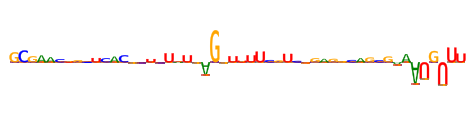

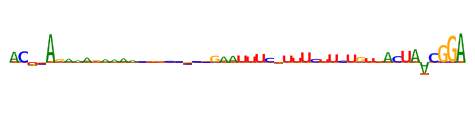

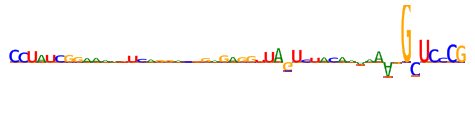

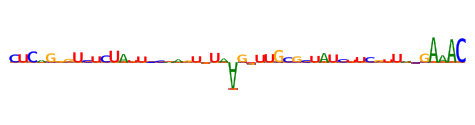

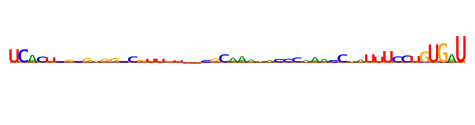

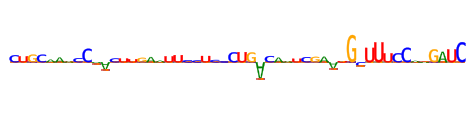

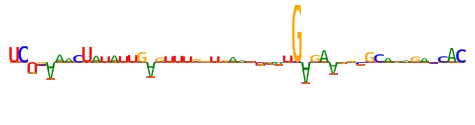

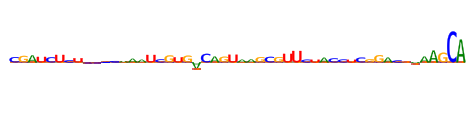

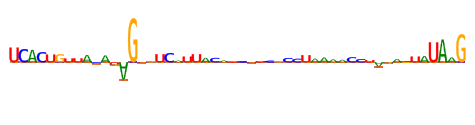

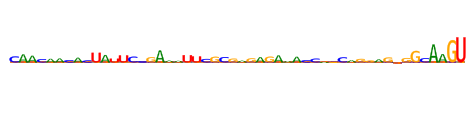

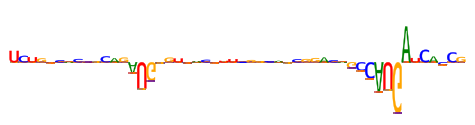

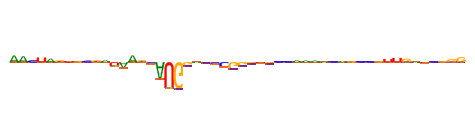

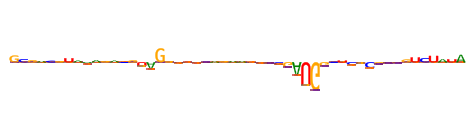

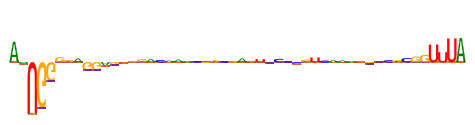

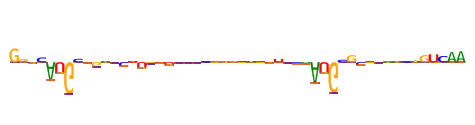

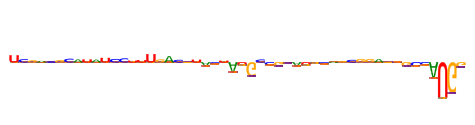

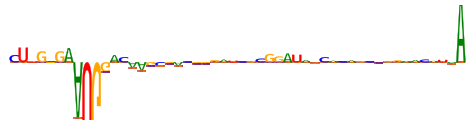

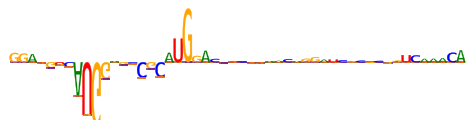

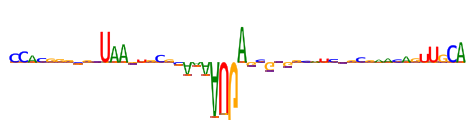

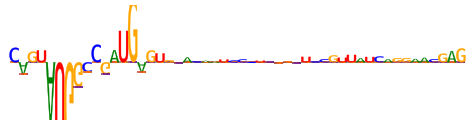

In [162]:
for i in range(10):
    plot_logo(attrib_top[i], name="contrib_top" + str(i))
for i in range(10):
    plot_logo(attrib_min[i], name="contrib_min" + str(i))

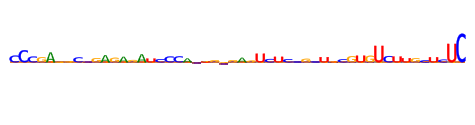

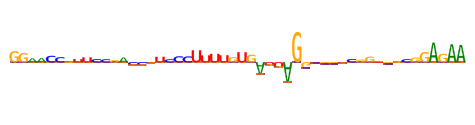

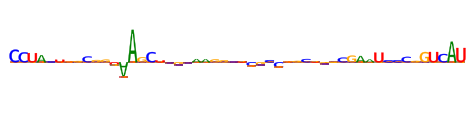

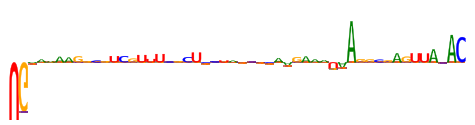

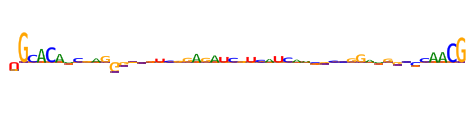

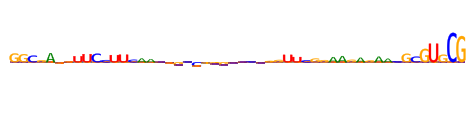

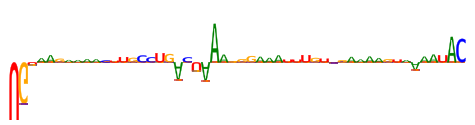

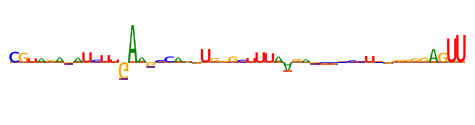

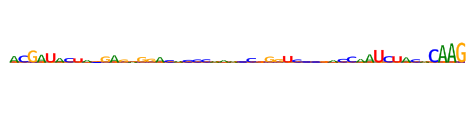

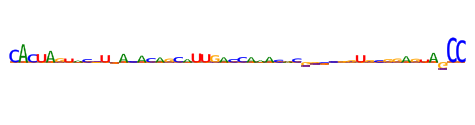

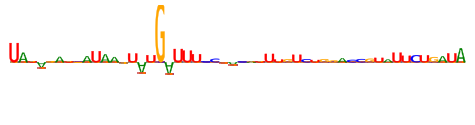

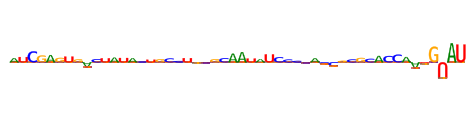

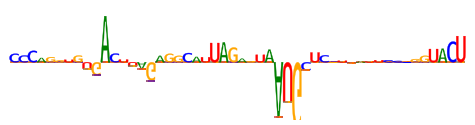

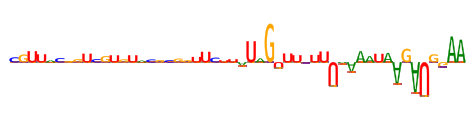

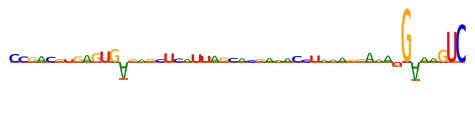

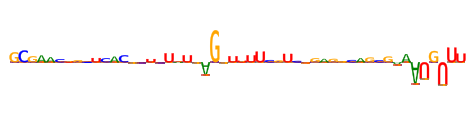

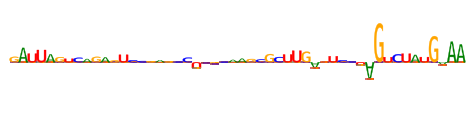

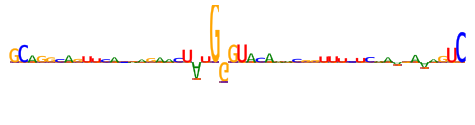

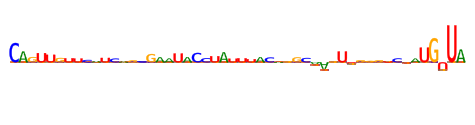

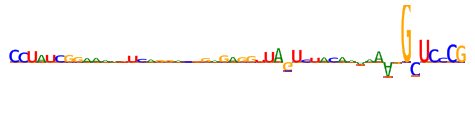

In [163]:
for i in range(10):
    plot_logo(attrib_nonaug_low[i], name="contrib_nonaug_low" + str(i))
for i in range(10):
    plot_logo(attrib_aug_high[i], name="contrib_aug_high" + str(i))